In [1]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import tifffile as tiff
import seaborn as sns
import pickle

c:\Users\thu71\AppData\Local\anaconda3\envs\cellpose\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\thu71\AppData\Local\anaconda3\envs\cellpose\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\thu71\AppData\Local\anaconda3\envs\cellpose\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()

df_meta_path = data_dir / 'specificity' / 'metadata' / 'imgs.csv'
df_imgs = pd.read_csv(df_meta_path)


In [5]:
# df_imgs['Condition'] = ['KO', 'Control']

In [6]:
df_imgs

,Condition,FOV,Path
0,Control,cycle1 PLA,y:\coskun-lab\Thomas\23_PLA_revision\data\spec...
1,KO,cycle1 PLA,y:\coskun-lab\Thomas\23_PLA_revision\data\spec...


# PLA quantification

In [13]:
import PLA

PPI_save_path =  data_dir / 'specificity'  / 'PPI'
PPI_save_path.mkdir(parents=True, exist_ok=True)

In [14]:
for row in df_imgs.itertuples():
    path = row.Path
    with h5py.File(path, 'r') as f:
        markers = f['cycle1'].attrs['Markers']
    print(markers)


['DNA' 'cyclin D1/CDK4' 'Bim/Tom20']
['DNA' 'cyclin D1/CDK4' 'Bim/Tom20']


In [15]:
RNAs = ['cyclin D1/CDK4', 'Bim/Tom20']

for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    pla_detect = PLA.PLA_detection(path, name='cycle1', m='Markers')
    
    with h5py.File(path, 'r') as f:
        markers = f['cycle1'].attrs['Markers']
        
    imgs_spots = []
    imgs_wths = []
    for RNA in RNAs: 
        if RNA in markers:
            img_spot, img_wth, _, img = pla_detect.detect_spot(RNA, thres=0.03, min_radius=2)
            imgs_spots.append(img_spot)
            imgs_wths.append(img_wth)
        
    # Save PPI dict
    name = row[1] +'.pkl'
    pla_detect.save_pickle(PPI_save_path / name)


Reading image cyclin D1/CDK4
Processing image cyclin D1/CDK4
(array([0, 1], dtype=uint8), array([16057365,    42264], dtype=int64))
Reading image Bim/Tom20
Processing image Bim/Tom20
(array([0, 1], dtype=uint8), array([16021393,    78236], dtype=int64))
File exist. Deleted
Reading image cyclin D1/CDK4
Processing image cyclin D1/CDK4
(array([0, 1], dtype=uint8), array([15971475,    49532], dtype=int64))
Reading image Bim/Tom20
Processing image Bim/Tom20
(array([0, 1], dtype=uint8), array([15935498,    85509], dtype=int64))
File exist. Deleted


In [16]:
# import napari

# viewer = napari.view_image(np.stack(imgs_wths))
# viewer.add_image(np.stack(img))
# viewer.add_image(np.stack(imgs_spots), contrast_limits=[0,1], blending='additive')

# QC segmentation

In [17]:
from skimage import morphology, measure
from skimage.segmentation import clear_border
from collections import defaultdict
   
def count_pixel_label_mask(regionmask, intensity_image):
    v,c = np.unique(intensity_image[regionmask], return_counts=True)
    return dict(zip(v,c))
    
# Quality control of mask
def qc_nuclei(mask_cyto, mask_nuclei, small_size=2000):
    '''
    Function to check if cell masks contain nuclei
    '''
    # Dictionnary storing nuclei and cyto label to cell id 
    nuclei2cell = {}
    cyto2cell = {}
    
    # Filter out small objects
    mask_cyto = morphology.remove_small_objects(mask_cyto,  min_size=small_size)
    
    # Filter out mask touching border
    mask_nuclei = clear_border(mask_nuclei)
    
    # Filtered only cell mask region
    cell_mask = np.where(mask_cyto > 0, 1, 0)
    mask_nuclei_filtered = mask_nuclei * cell_mask
    mask_nuclei_filtered =  morphology.remove_small_objects(mask_nuclei_filtered,  min_size=small_size)
    
    nuclei_mask = np.where(mask_nuclei>0, 1, 0)
    cyto = (mask_cyto - mask_cyto*nuclei_mask).astype(np.uint16)
    
    # Count pixel cell label in each nuclei region to assign each nuclei to cell
    props = measure.regionprops(mask_nuclei_filtered, intensity_image=mask_cyto, 
                    extra_properties=(count_pixel_label_mask,))
    nuclei_labels = []
    cell_labels = []
    for prop in props:
        df = pd.DataFrame.from_dict(prop['count_pixel_label_mask'], orient='index').reset_index()
        df.columns = ['Label', 'Count']
        corresponding_label = df.iloc[df['Count'].argmax(axis=0)]['Label']
        nuclei_labels.append(prop['Label'])
        cell_labels.append(corresponding_label)
    
    df = pd.DataFrame({'Nuclei': nuclei_labels, 'Cyto': cell_labels})
    return mask_cyto, mask_nuclei_filtered, cyto, df

In [100]:
# Read masks paths 
mask_dir = data_dir /  'specificity' / 'imgs' / 'masks'
mask_filt_dir = data_dir /  'specificity' / 'imgs' / 'masks_filtered'
mask_filt_dir.mkdir(parents=True, exist_ok=True)

masks_path = defaultdict(dict) 
for path in os.listdir(mask_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_dir / path
    else:
        masks_path[name]['cyto'] = mask_dir / path


In [101]:
for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    name = row[1]
    with h5py.File(path, 'r') as f:
        s = f['cycle1'][:].shape

    # Read masks
    mask_cyto_path = masks_path[name]['cyto']
    mask_nuclei_path = masks_path[name]['nuclei']
    
    m = skimage.io.imread(mask_cyto_path)
    m = m[:s[1], :s[2]]

    mask_nuclei = skimage.io.imread(mask_nuclei_path)

    mask_cyto = np.zeros(mask_nuclei.shape, dtype=np.uint8)
    mask_cyto[:m.shape[0],:m.shape[1]] = m

    cell, nuclei, cyto, df = qc_nuclei(mask_cyto, mask_nuclei)
    
    file_path =  mask_filt_dir / f'Nuclei_{name}.tif'
    tiff.imwrite(file_path, nuclei)
    file_path =  mask_filt_dir / f'Cell_{name}.tif'
    tiff.imwrite(file_path, cell)
    file_path =  mask_filt_dir / f'Cyto_{name}.tif'
    tiff.imwrite(file_path, cyto)
    file_path =  mask_filt_dir / f'df_{name}.csv'
    df.to_csv(file_path, index=False)

In [102]:
# import napari

# viewer = napari.Viewer()
# viewer.add_labels(nuclei)
# viewer.add_labels(cell)

# Extract per cell PPI count

In [112]:
import pickle 

def read_PPI(path):
    with open(path, 'rb') as file:
        PPI_dict = pickle.load(file)

    return PPI_dict

def create_PPI_df(PPI_labels, PPI_loc, name, cyto=True):
    if cyto:
        columns_name = ['Cyto', 'x', 'y']
    else:
        columns_name = ['Nuclei', 'x', 'y']
    df = pd.DataFrame(np.hstack([PPI_labels[:,np.newaxis], PPI_loc]), 
                      columns=columns_name)
    df['PPI'] = name
    return df

In [113]:
mask_filt_dir = data_dir / 'specificity' / 'imgs' / 'masks_filtered'
PPI_save_path =  data_dir / 'specificity'  / 'PPI'

masks_path = defaultdict(dict) 
for path in os.listdir(mask_filt_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_filt_dir / path
    elif 'Cyto' in name:
        masks_path[name[5:]]['cyto'] =mask_filt_dir / path
    elif 'Cell' in name:
        masks_path[name[5:]]['cell'] =mask_filt_dir / path    
    elif 'df' in name:
        masks_path[name[3:]]['df'] =mask_filt_dir / path
    else:
        pass

In [132]:
for row in df_imgs.itertuples():
    name = '_'.join(row[1:2])
    
    # Read masks
    mask_cyto_path = masks_path[name]['cell']
    mask_nuclei_path = masks_path[name]['nuclei']
    df_path =  masks_path[name]['df']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    df_cell_info = pd.read_csv(df_path)
    nuclei2cell = dict(zip(df_cell_info.iloc[:,0], df_cell_info.iloc[:,1]))   
    
    # Read PPi
    PPI_dict = read_PPI(PPI_save_path / f'{name}.pkl')
    dfs_PPI_cyto = []
    dfs_PPI_nuclei = []
    for k in PPI_dict.keys():
        PPI_loc = PPI_dict[k][:, 1:3].astype(np.uint32)
        
        # Cyto
        PPI_labels = mask_cyto[PPI_loc[:,0], PPI_loc[:,1]]
        df_PPI = create_PPI_df(PPI_labels, PPI_loc, k)
        dfs_PPI_cyto.append(df_PPI)
        
        # Nuclei
        PPI_labels = mask_nuclei[PPI_loc[:,0], PPI_loc[:,1]]
        df_PPI = create_PPI_df(PPI_labels, PPI_loc, k, cyto=False)
        dfs_PPI_nuclei.append(df_PPI)
    
    # Combined DFs
    df_PPI_cyto = pd.concat(dfs_PPI_cyto)
    df_PPI_nuclei = pd.concat(dfs_PPI_nuclei)
    df_PPI_nuclei['Nuclei_Cell'] = df_PPI_nuclei['Nuclei'].apply(lambda x: nuclei2cell.get(x,x))   
    df_merged = df_PPI_cyto.merge(df_PPI_nuclei)
    df_merged['Condition'] = row[1]
    df_merged['FOV'] = row[2]
    
    # Save dataframe
    path = PPI_save_path / f'{name}.csv'
    df_merged.to_csv(path, index=False)

# PPI quantification

In [52]:
PPI_save_path =  data_dir / 'specificity'  / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        df['Condition'] = df['Condition'].apply(lambda x: {'KO': 'Control', 'Control': 'KO'}.get(x,x))
        df['PPI'] = df['PPI'].apply(lambda x: {'cyclin D1/CDK4':'sox2/oct4'}.get(x,x))
        dfs.append(df)

df = pd.concat(dfs)

In [53]:
df

,Cyto,x,y,PPI,Nuclei,Nuclei_Cell,Condition,FOV
0,3,2991,400,sox2/oct4,178,3.0,KO,cycle1 PLA
1,1,933,257,sox2/oct4,50,1.0,KO,cycle1 PLA
2,8,32,3263,sox2/oct4,3,8.0,KO,cycle1 PLA
3,9,2122,4256,sox2/oct4,122,9.0,KO,cycle1 PLA
4,9,2262,4208,sox2/oct4,132,9.0,KO,cycle1 PLA
...,...,...,...,...,...,...,...,...
3855,3,976,2469,Bim/Tom20,59,3.0,Control,cycle1 PLA
3856,7,2188,2232,Bim/Tom20,0,0.0,Control,cycle1 PLA
3857,2,1643,471,Bim/Tom20,0,0.0,Control,cycle1 PLA
3858,7,2282,2902,Bim/Tom20,0,0.0,Control,cycle1 PLA


In [54]:
nuclei_count = df.groupby(['Condition', 'Cyto'])['Nuclei'].nunique().reset_index()
nuclei_count.columns=['Condition', 'Id', 'N_nuclei']
nuclei_count['N_nuclei'] -= 1

In [55]:
g = df.groupby(['Condition', 'FOV', 'PPI', 'Cyto']).size()
df_cell = pd.DataFrame({'Count Cyto': g}).reset_index()
df_cell = df_cell[df_cell.Cyto != 0]
df_cell.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_cell']

g = df.groupby(['Condition', 'FOV', 'PPI', 'Nuclei_Cell']).size()
df_nuclei = pd.DataFrame({'Count Nuclei': g}).reset_index()
df_nuclei= df_nuclei[df_nuclei.Nuclei_Cell != 0]
df_nuclei.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_nuclei']

In [56]:
df_all = df_cell.merge(df_nuclei, how='left', on=['Condition', 'FOV', 'PPI', 'Id']).fillna(0)
df_all['Count_cyto'] = df_all['Count_cell'] - df_all['Count_nuclei']

In [57]:
df_all = df_all.merge(nuclei_count, how='left', on=['Condition', 'Id'])
df_all['Count_per_cell'] = df_all['Count_cell'].div(df_all['N_nuclei'])
df_all['Count_per_cytol'] = df_all['Count_cyto'].div(df_all['N_nuclei'])
df_all['Count_per_nuclei'] = df_all['Count_nuclei'].div(df_all['N_nuclei'])

In [58]:
from statannotations.Annotator import Annotator

In [65]:
def plot(plotting, figsize=(7,7)):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1.5):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        ax = sns.swarmplot(**plotting, ax=ax, dodge=True, linewidth=1,edgecolor='gray')
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
        result = annot.apply_test().annotate()
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

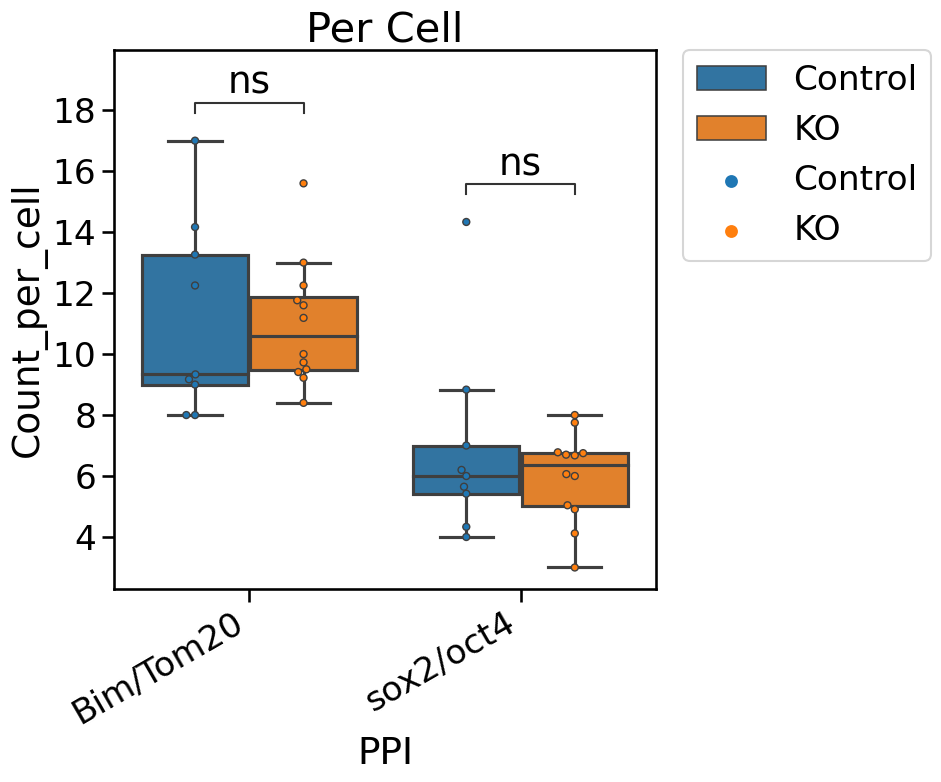

In [66]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_per_cell",
    "hue": "Condition"
}

plot(plotting)
plt.title('Per Cell', size=30)
plt.show()  


Text(0.5, 1.0, 'Per Nuclei')

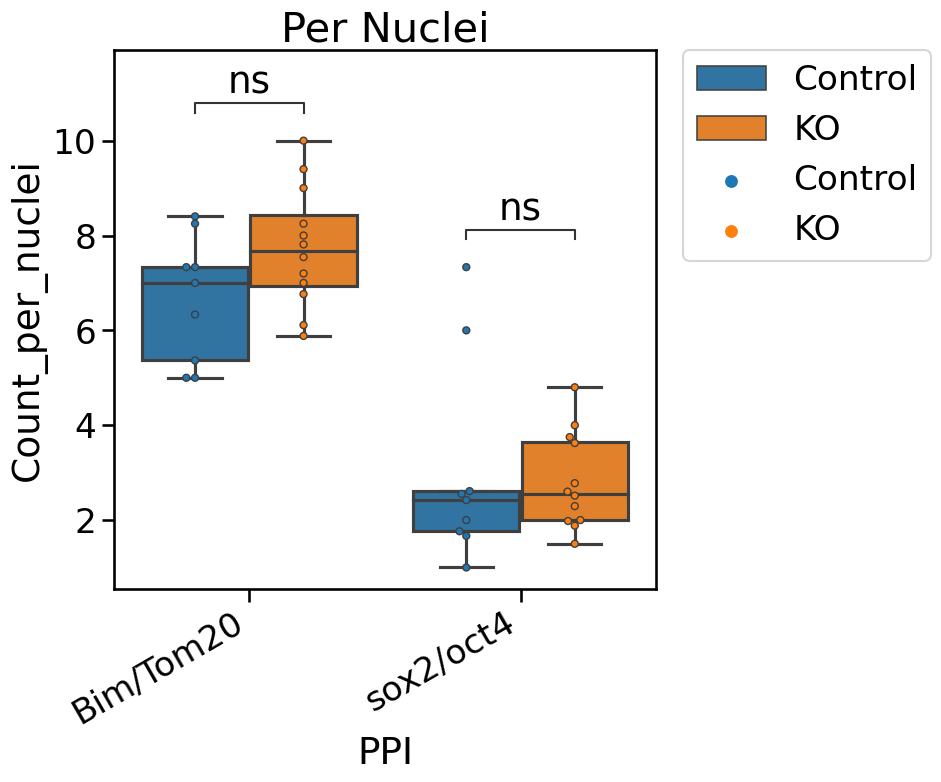

In [67]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_per_nuclei",
    "hue": "Condition"
}

plot(plotting)
plt.title('Per Nuclei', size=30)


Text(0.5, 1.0, 'Per Cytosol')

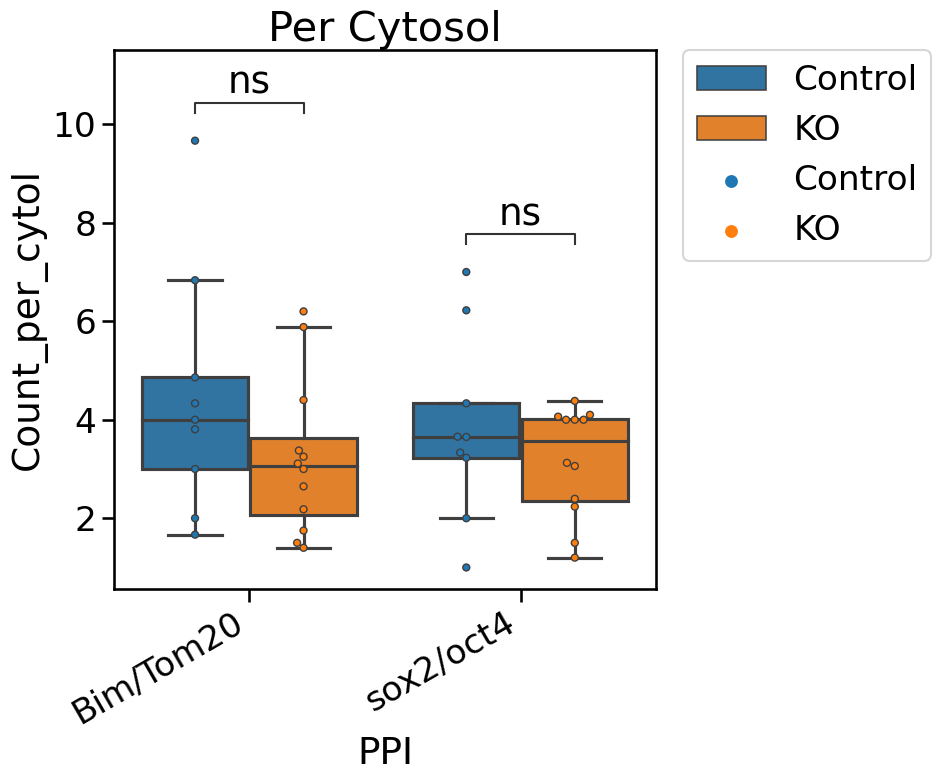

In [68]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_per_cytol",
    "hue": "Condition"
}

plot(plotting)
plt.title('Per Cytosol', size=30)
